In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import utils
from pylab import rcParams
from textblob import TextBlob
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langdetect import detect

import sys
sys.path.insert(1, '/Users/deepshika/Desktop/gitpros/projects/E-commerce-product-review-analysis/utils')
from utils import utils
rf = utils.review_feature()

rcParams['figure.figsize'] = 10,7
nlp = spacy.load("en_core_web_sm")


In [4]:
# importing data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [5]:
train.head(10)

,product,answer_option,label
0,Accucheck,Fast and accurate delivery,0
1,Accucheck,As usual it is genuine,0
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0
3,Accucheck,fwegwrqdsdvwfg,0
4,Accucheck,These strips were as per my requirment,0
5,Accucheck,Fast service was good,0
6,Accucheck,Received 10 strips and 2 packets of lancets .....,0
7,Accucheck,Does not fit my machine,0
8,Accucheck,Discount and quick response,0
9,Accucheck,Fast delivery with good packing.,0


0 - uninformative, 1 - informative

In [6]:
train.shape

(1676, 3)

In [7]:
# check null values
train.isnull().sum()

product          0
answer_option    0
label            0
dtype: int64

No null values

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product        1676 non-null   object
 1   answer_option  1676 non-null   object
 2   label          1676 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 39.4+ KB


In [9]:
train.describe()

,label
count,1676.000000
mean,0.299523
std,0.458186
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
# checking for imbalances
train['label'].value_counts(normalize=True)

0    0.700477
1    0.299523
Name: label, dtype: float64

There is an imbalance of classes with 70% being uninformative(0) and only 30% being informative(1)

In [11]:
train.loc[900]

product               Neurobion
answer_option    Good for nerve
label                         1
Name: 900, dtype: object

In [12]:
train.loc[1500]

product          Accucheck
answer_option    I like it
label                    0
Name: 1500, dtype: object

In [13]:
# Analysis per product
prod_analysis = pd.crosstab(train['product'], train['label'], margins=True)
prod_analysis

label,0,1,All
product,,,
Accucheck,317,85,402
Becadexamin,53,27,80
Evion,89,33,122
Neurobion,286,137,423
SevenseascodLiverOil,60,22,82
Shelcal,262,126,388
Supradyn,50,23,73
shampoo,57,49,106
All,1174,502,1676


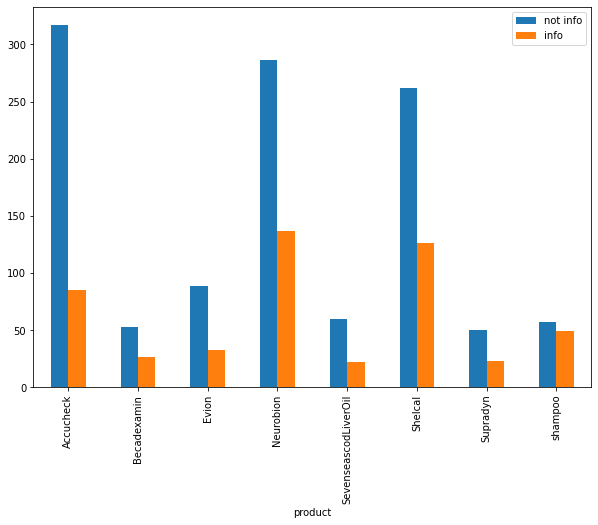

In [14]:
prod_analysis = prod_analysis.reset_index()
prod_analysis.columns = ['product', 'not info', 'info', 'All']
prod_analysis.iloc[:-1].plot(x='product', y=['not info', 'info'], kind='bar');

From the graph it can be seen that most reviews are not useful/informative especially for products like Accucheck, Neurobion and Shelcal.

In [15]:
# checking the length of reviews
train['review_len'] = train['answer_option'].apply(lambda x : len(x.split()))

In [16]:
train.head()

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,fwegwrqdsdvwfg,0,1
4,Accucheck,These strips were as per my requirment,0,7


In [17]:
train.groupby('label').median()

,review_len
label,
0,4.0
1,6.0


In [18]:
train.groupby('label').mean()

,review_len
label,
0,6.360307
1,7.721116


In [19]:
train['review_len'].mode()

0    4
Name: review_len, dtype: int64

In [20]:
train.describe()

,label,review_len
count,1676.000000,1676.000000
mean,0.299523,6.767900
std,0.458186,6.830254
min,0.000000,1.000000
25%,0.000000,3.000000
50%,0.000000,5.000000
75%,1.000000,8.000000
max,1.000000,79.000000


![data](./images/data-processing.jpg)

In [21]:
train['answer_option']

0                              Fast and accurate delivery
1                                 As usual it is genuine 
2       Behavior of delivery boy is very bad. Delivery...
3                                          fwegwrqdsdvwfg
4                  These strips were as per my requirment
                              ...                        
1671                                                Ft GM
1672                                               I like
1673                          Nice price with long expiry
1674                                      Price & Service
1675                                        Good discount
Name: answer_option, Length: 1676, dtype: object

## Stage 1: Language Detection

In [22]:
bad_reviews = []
for idx in train.index:
    review = train.at[idx, 'answer_option']
    try:
        b = rf.lang_detect(review)
        if b == 'hi' or b == 'mr':
            bad_reviews.append(idx)
    except:
        bad_reviews.append(idx)
        print('language exception for: ', review)



language exception for:  😕🤔😕🤣😕🤣😢😨😔😭😃😁😣😨😁🤦‍♂️😨☺😣😔😨😛🤦‍♂️😢☺👍🙈😨😕😔😊😢😕😔🙈😨😣🤦‍♂️👍😁🤦‍♂️🙈😁🤦‍♂️😂😕😔😊😨👍😂😢👍😂🙈😢👍😂😭👍😂😭😕🙈👍😕😂☺😕😂😂😣😂😕👍😢😕🤦‍♂️😂😢🤔🙈😕🤦‍♂️🙈😢🤔😂🤦‍♂️🙈🤔😔😣😣👆🙈🤔😔😕😕😨🤣😔😕🙈😊😨😣😣🙈😊😕😂🤔😕😢🤔👍🤣😨😕😭😨😕😭😨😕😭😕👍😭😕😕🤣👍😁😭👍👍😭😕😣🙈😕😣😢😣😣😨😣😛😨😭😣😢😭😨😛😨🤣😢😨😂😊🤔😊🙈🙈🙈😭🐂🐎🐷🐎🐂🐈🐱🐮🦓🐱🐄🦌🦔🌹🥀⚘🌸🏵🌲🌷🌸⚘🌱🥔🍑🍓🍆🥝🍐🥑🥕🍆🍏🥝🍓🥔🥝🍆🥔🥑🥝🥝🥝🍒🥔🥑🥝🍏🍏🥑🥔🍐🍏🥑🥔🥔🥔🍆🍏🍏🍓🍇🥕🍏🍓🍏🍓🍏🥔🍐🍐🥔🍐🥔🥔🍐🥔🥑🍓🍏🍓🥝🍓🥑🍓🥑🍓🥑🥕🍐🥕🍏🍓🍇🍑🍈🥑🍇🥑🍏🍍🥑🍓🍏🍓🍇🍆🍎🥔🥝🍓🍐🍒🍇🍓🥑🍌🍏🍆🥝🍆🥝🍆🍏🍓🥑🍓🍎🍄🥝🍒🥥🍒🥝🥔🥦🍓🍆🍅🍏🥔🥝🥕🥑🍓🍏🥔🥝🥔🥝🍓🥘🥙🥘🌮🍕🌮🍕🌯🥘🥚🥩🥓🍖🌯🥘🍟🌭🥓🍳🥓🥪🥚🍖🍗🍕🥙🌭🍔🌭🍿🌭🥙🏌️‍♂️🥋🏓🎳🏓🏏🏓🥅🏌️‍♂️🥊🏌️‍♂️🎳⛳🏏⛳    🤼‍♀️🏍🤼‍♀️🤸‍♂️🤼‍♀️🤾‍♀️🤼‍♂️🏎🤹‍♂️🤺🤼‍♀️🏎🤼‍♂️       🎳🏸🥅🏸🥋🏌️‍♂️🎿🏚🏛🏝🏣🏙🌋🏜🏛🏝         🎙🎤🎶🎧📲🎤🎸📱🎙🎧🎷🎤🎸📻📲🎚🎧🎸🎼🎸📺📷📽📷📽📷📽🔬📽🔬📽🔬    🎸🥁🎙🎤🎚🎧🎸🥁🥁🎸🎤☎️🎸🎻🎸📱🎚🎤🎸🎤☎️🎧🎸🎤🎙🎤🎤☎️📻☎️🎧🎸🎸🎤🎤☎️🎤🎸🎤🎸🎤🎸🎧🎸🎸🎧🎧🎸🎸🎧🎸🎧📻🎸🎸🎧🎧🎸🎧🎸🎧🎸🎤🎸🎤☎️🎧


In [23]:
print('Number of bad reviews at Stage 1:', len(bad_reviews))

Number of bad reviews at Stage 1: 3


In [24]:
train[train.index.isin(bad_reviews)]

,product,answer_option,label,review_len
898,Neurobion,अच्छा है,0,2
1042,Neurobion,😕🤔😕🤣😕🤣😢😨😔😭😃😁😣😨😁🤦‍♂️😨☺😣😔😨😛🤦‍♂️😢☺👍🙈😨😕😔😊😢😕😔🙈😨😣🤦‍♂...,0,5
1110,Shelcal,साहब बहुत धाँसू गोली है साला मेरा घुटना ख़राब ...,0,23


In [25]:
# remove the bad reviews
train = train.drop(bad_reviews).reset_index(drop=True)

## Stage 2: Gibberish Detection

Removing reviews like nkhkjhjkh, llhhjkhk, etc.

Using a pretrained model

Source: https://github.com/rrenaud/Gibberish-Detector

In [26]:
bad_reviews = []

for idx in train.index:
    review = train.at[idx, 'answer_option']
    if rf.gibberish_detection(review, prefix_path='./utils'):
        bad_reviews.append(idx)

In [27]:
print('Number of bad reviews at Stage 2:', len(bad_reviews))

Number of bad reviews at Stage 2: 8


In [28]:
train[train.index.isin(bad_reviews)]

,product,answer_option,label,review_len
3,Accucheck,fwegwrqdsdvwfg,0,1
82,Accucheck,qwerwetrjy,0,1
362,Neurobion,gehryetw,0,1
432,Shelcal,gehryetw,0,1
1449,Accucheck,ghyukuyujredfehrbv,0,1
1503,Accucheck,VVV. Good,0,2
1599,Accucheck,wqwasdbggn,0,1
1668,Accucheck,Ft GM,0,2


In [29]:
train = train.drop(bad_reviews)

In [30]:
train = train.reset_index(drop=True)

In [31]:
train

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,These strips were as per my requirment,0,7
4,Accucheck,Fast service was good,0,4
...,...,...,...,...
1660,Accucheck,Willingness to help,1,3
1661,Accucheck,I like,0,2
1662,Accucheck,Nice price with long expiry,0,5
1663,Accucheck,Price & Service,0,3


## Stage 3: Profanity Detection

* Profanities penalize SEO rankings
* Both english and hinglish profanities will be filtered out

In [32]:
bad_reviews = []

for idx in train.index:
    review = train.at[idx, 'answer_option']
    if rf.english_swear_check(review) or rf.hindi_swear_check(review):
        bad_reviews.append(idx)

In [33]:
print('Number of bad reviews at Stage 3:', len(bad_reviews))

Number of bad reviews at Stage 3: 3


In [34]:
train[train.index.isin(bad_reviews)]

,product,answer_option,label,review_len
140,shampoo,STOP SENDING ME SMS you assholes,0,6
1009,Neurobion,MotherFucker I dont want anything,1,5
1187,Shelcal,"SHELLCALL IS TAKEN BYYOU WIFE, BECAUSE SHE HAS...",1,22


In [36]:
train = train.drop(bad_reviews).reset_index(drop=True)

In [37]:
train

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,These strips were as per my requirment,0,7
4,Accucheck,Fast service was good,0,4
...,...,...,...,...
1657,Accucheck,Willingness to help,1,3
1658,Accucheck,I like,0,2
1659,Accucheck,Nice price with long expiry,0,5
1660,Accucheck,Price & Service,0,3


## Stage 4: Spelling Correction (Optional Stage)

In [38]:
for idx in train.index:
    review = train.at[idx, 'answer_option']
    train.at[idx, 'answer_option'] = rf.spell_correct(review, 0.9) # 0.9 is the confidence level

## Stage 4.1: Removing Company Names from Reviews

In [39]:
bad_reviews = []

for idx in train.index:
    review = train.at[idx, 'answer_option']
    if rf.competitive_brand_tag(review):
        bad_reviews.append(idx)

In [40]:
print('Number of bad reviews at Stage 4.1:', len(bad_reviews))

Number of bad reviews at Stage 4.1: 7


In [41]:
train[train.index.isin(bad_reviews)]

,product,answer_option,label,review_len
33,Accucheck,amazon products are better,0,4
348,Neurobion,Almost no discount on OTC products Pharmeasy &...,0,20
444,Shelcal,papal payment method was not working Product w...,0,9
615,SevenseascodLiverOil,Cheaper on amazon,0,3
941,Neurobion,Amazon has better quality for products,0,6
1057,Neurobion,Almost no discount on OTC products Pharmeasy &...,0,20
1324,Shelcal,grofer is best,1,3


In [42]:
train = train.drop(bad_reviews).reset_index(drop=True)

In [43]:
train

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad Delivery ...,0,20
3,Accucheck,These strips were as per my requirement,0,7
4,Accucheck,Fast service was good,0,4
...,...,...,...,...
1650,Accucheck,Willingness to help,1,3
1651,Accucheck,I like,0,2
1652,Accucheck,Nice price with long expire,0,5
1653,Accucheck,Price & Service,0,3


In [44]:
train.to_csv('./data/preprocessed_reviews.csv', index=False)

* Initial review count was 1676 and after processing it has reduced to 1655
* By preprocessing we are reducing false positives